# Rede Neural Multi Layer Perceptron (MLP) em PyTorch

**Descrição**
Este notebook apresenta a implementação didática de uma Rede Neural do tipo Multi Layer Perceptron (MLP) utilizando o framework PyTorch. A arquitetura considerada possui uma única camada oculta com função de ativação logística (sigmoid) e uma camada de saída linear. Diferentemente da implementação “from scratch” com NumPy, aqui exploramos o mecanismo de diferenciação automática (autograd) do PyTorch, que abstrai o cálculo explícito dos gradientes e simplifica o processo de treinamento.

**Objetivo**
Demonstrar como a mesma arquitetura conceitual de uma MLP pode ser implementada de forma mais concisa e robusta com PyTorch, evidenciando as vantagens do uso de bibliotecas de deep learning modernas. O notebook busca reforçar o entendimento de que, apesar da automação do cálculo dos gradientes, os princípios matemáticos subjacentes — propagação direta, função de perda e gradiente descendente — permanecem exatamente os mesmos.


**Funcionamento**

A MLP recebe valores de entrada escalares que são processados por uma camada linear seguida de uma função de ativação sigmoid, introduzindo não linearidade ao modelo. As ativações da camada oculta são então combinadas por uma segunda camada linear, responsável por produzir a saída final da rede.

O erro entre a saída predita e o valor real é medido por meio do **Erro Quadrático Médio (MSE)**. Durante o treinamento, o PyTorch constrói automaticamente o grafo computacional associado às operações realizadas no *forward pass*. A chamada ao método `backward()` aplica a regra da cadeia de forma automática, calculando os gradientes do erro em relação a todos os parâmetros treináveis da rede.

A atualização dos pesos e vieses é realizada pelo otimizador **Stochastic Gradient Descent (SGD)**, que ajusta os parâmetros iterativamente com base nos gradientes calculados e na taxa de aprendizado definida. Ao longo das épocas, o erro médio é armazenado, permitindo analisar a convergência do modelo e sua capacidade de aproximar funções não lineares, como a função seno utilizada no experimento.

Esse exemplo ilustra como o PyTorch permite focar na **modelagem e experimentação**, reduzindo a complexidade do código sem ocultar os fundamentos teóricos do aprendizado em redes neurais multicamadas.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

## Verificação da presença da GPU

In [2]:
print(torch.__version__) # Versão do torch
print(torch.cuda.is_available()) # Verificação de GPU
print(torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", device)

2.5.1+cu121
True
NVIDIA GeForce RTX 4050 Laptop GPU
Usando: cuda


## Modelagem da MLP em PyTorch

In [3]:
class MLP(nn.Module):
    """
    MLP com:
    - 1 camada oculta (sigmoid)
    - camada de saída linear
    """

    def __init__(self, n_hidden: int):
        """
        Parâmetros:
        ----------
        n_hidden : int
            Número de neurônios na camada oculta.
        """
        super().__init__()

        self.hidden = nn.Linear(1, n_hidden)
        self.activation = nn.Sigmoid()
        self.output = nn.Linear(n_hidden, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.
        """
        z1 = self.hidden(x)
        a1 = self.activation(z1)
        y_hat = self.output(a1)
        return y_hat


In [4]:
def treinar_mlp(
    model: MLP,
    x: torch.Tensor,
    y: torch.Tensor,
    lr: float = 0.01,
    epocas: int = 2000
):
    """
    Loop de treinamento.
    """
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    historico_erro = []

    for _ in range(epocas):
        # Forward
        y_hat = model(x)
        loss = criterion(y_hat, y)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        historico_erro.append(loss.item())

    return historico_erro


In [5]:
# Dados (exemplo: sen(x))
x_np = torch.linspace(0, 2 * torch.pi, 300).unsqueeze(1)
y_np = torch.sin(x_np)

x_np = x_np.to(device)
y_np = y_np.to(device)

# Modelo
model = MLP(n_hidden=10).to(device)

# Treinamento
historico_erro = treinar_mlp(
    model=model,
    x=x_np,
    y=y_np,
    lr=0.05,
    epocas=5000
)


## Gráfico da aproximação

In [6]:
model.eval()
with torch.no_grad():
    y_pred = model(x_np)

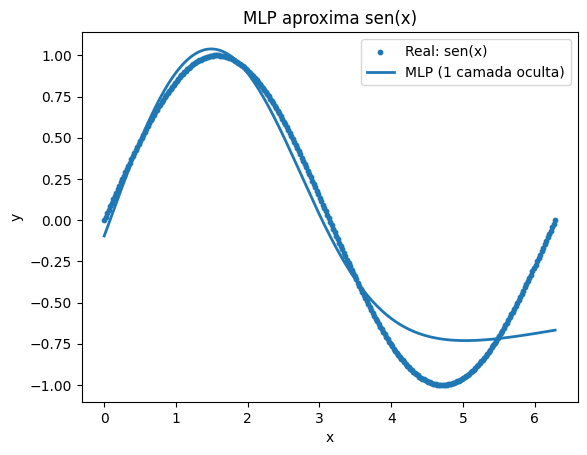

In [7]:
x_plot = x_np.cpu().numpy()
y_real = y_np.cpu().numpy()
y_pred_plot = y_pred.cpu().numpy()

# Plot
plt.figure()
plt.scatter(x_plot, y_real, s=10, label="Real: sen(x)")
plt.plot(x_plot, y_pred_plot, linewidth=2, label="MLP (1 camada oculta)")
plt.title("MLP aproxima sen(x)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## Curva do erro

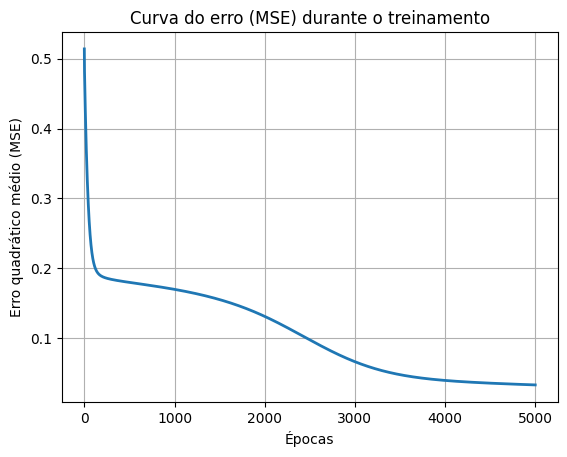

In [8]:
erro = np.array(historico_erro)

plt.figure()
plt.plot(erro, linewidth=2)
plt.title("Curva do erro (MSE) durante o treinamento")
plt.xlabel("Épocas")
plt.ylabel("Erro quadrático médio (MSE)")
plt.grid(True)
plt.show()